In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import backward
# from coolmom import SGD
import math

import numpy as np
import pickle
import os
from sklearn.utils import shuffle
from tqdm import tqdm
import ipdb

import Utils.util as util

np.random.seed(0)
torch.manual_seed(999)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(999)
    torch.cuda.empty_cache()

### EEG data

In [2]:
CRASH_fname = 'CRASH_FE_filtered_subsampled_noscaler.pkl'

with open(CRASH_fname, 'rb') as handle:
    F_t, scs, adj_mx, adj_mx_idx, _input, _gt, coeffs, \
    inv_mapping, region_assignment, nTrain, nValid, \
    nTest, scaler_in, scaler_out = pickle.load(handle)
    
subj_cls = np.load('subj_cls.npy')
subj_cls = subj_cls[adj_mx_idx]

unique_cls = list(set(subj_cls))
_subj_cls = subj_cls.copy()
for cls_i in range(len(unique_cls)):
    _subj_cls[subj_cls == unique_cls[cls_i]] = cls_i

(245952, 1456, 1) (245952,)


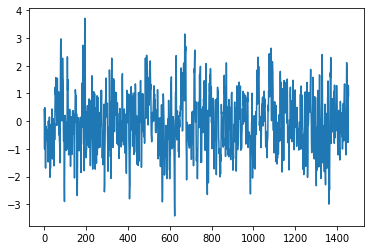

In [3]:
device = 'cuda:0'
# prep EEG data
_, num_t, num_nodes = _gt.shape

x = _gt.transpose(0,2,1).reshape(-1, num_t)[...,None]
y = _subj_cls.repeat(num_nodes)
print(x.shape, y.shape)

num_nodes = 4 # control train val test size for memory
nTrain, nValid, nTest = num_nodes*nTrain, num_nodes*nValid, num_nodes*nTest

plt.plot(x[0,:,0])
# plt.plot(y[0,0])
# plt.plot(np.concatenate((x[20,0],y[20,0]), 0))

x = torch.tensor(x).to(device)
y = torch.tensor(y).to(device)


### fMRI data

In [14]:
fmri_mat = np.load('filtered_F.npy')
subj_cls = np.load('subj_cls.npy')

print(fmri_mat.shape, subj_cls.shape)

unique_cls = list(set(subj_cls))
_subj_cls = subj_cls.copy()
for cls_i in range(len(unique_cls)):
    _subj_cls[subj_cls == unique_cls[cls_i]] = cls_i

(192, 320, 200) (192,)


(38400, 320, 1) (38400,)
26880 5760 5760


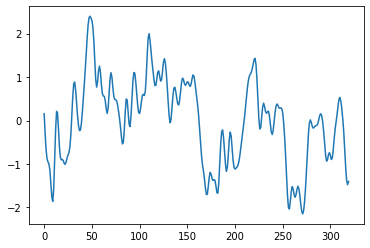

In [44]:
device = 'cuda:0'

_, num_t, num_nodes = fmri_mat.shape

x = fmri_mat.transpose(0,2,1).reshape(-1, num_t)[...,None]
y = _subj_cls.repeat(num_nodes)
x, y = shuffle(x, y)
print(x.shape, y.shape)

# num_nodes = 4 # control train val test size for memory
nTrain, nValid, nTest = int(0.7*len(y)), int(0.15*len(y)), int(0.15*len(y))
print(nTrain, nValid, nTest)
plt.plot(x[0,:,0])
# plt.plot(y[0,0])
# plt.plot(np.concatenate((x[20,0],y[20,0]), 0))

x = torch.tensor(x).to(device)
y = torch.tensor(y).to(device)

In [45]:
def t2v(tau, f, out_features, w, b, w0, b0, arg=None):
    if arg:
        v1 = f(torch.matmul(tau, w) + b, arg)
    else:
        v1 = f(torch.matmul(tau, w) + b)
    v2 = torch.matmul(tau, w0) + b0
    #print(v1.shape)
    return torch.cat([v1, v2], 2)

class SineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(SineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.f = torch.sin

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

class CosineActivation(nn.Module):
    def __init__(self, in_features, out_features):
        super(CosineActivation, self).__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.f = torch.cos

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
    pad = (kernel_size - 1) * dilation
    return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

class Model(nn.Module):
    def __init__(self, activation, dropout=0.3,
                residual_channels=32, dilation_channels=32, skip_channels=256,
                end_channels=64, kernel_size=2, blocks=4, layers=2):
        super(Model, self).__init__()
        if activation == "sin":
            self.l1 = SineActivation(1, residual_channels)
        elif activation == "cos":
            self.l1 = CosineActivation(1, residual_channels)
    
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.device = device

        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.bn = nn.ModuleList()
        
        multi_factor = 2
        for b in range(blocks):
            additional_scope = kernel_size - 1
            new_dilation = 1
            for i in range(layers):
                # dilated convolutions
                self.filter_convs.append(CausalConv1d(residual_channels, dilation_channels, kernel_size, new_dilation))
                self.gate_convs.append(CausalConv1d(residual_channels, dilation_channels, kernel_size, new_dilation))

                # 1x1 convolution for residual connection
                self.residual_convs.append(nn.Conv1d(in_channels=dilation_channels,out_channels=residual_channels,kernel_size=1))

                # 1x1 convolution for skip connection
                self.skip_convs.append(nn.Conv1d(in_channels=dilation_channels,out_channels=skip_channels,kernel_size=1))
                self.bn.append(nn.BatchNorm1d(residual_channels))

                new_dilation *= multi_factor
                additional_scope *= multi_factor
                
#         # eeg
#         self.fc1 = nn.Linear(512, 128)
#         self.fc2 = nn.Linear(128, len(unique_cls))
    
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, len(unique_cls))
        
    def forward(self, x):
        #x = x.unsqueeze(1)
        x = self.l1(x).transpose(1,2)

        # WaveNet layers
        for i in range(self.blocks * self.layers):
            # print(i, x.shape)
            #            |----------------------------------------|     *residual*
            #            |                                        |
            #            |    |-- conv -- tanh --|                |
            # -> dilate -|----|                  * ----|-- 1x1 -- + --> *input*
            #                 |-- conv -- sigm --|     |
            #                                         1x1
            #                                          |
            # ---------------------------------------> + -------------> *skip*

            #(dilation, init_dilation) = self.dilations[i]

            #residual = dilation_func(x, dilation, init_dilation, i)
            residual = x #[batch_size, residual_dim, 80, 16]

            # dilated convolution
            filter = self.filter_convs[i](residual)
            filter = torch.tanh(filter[:, :, :-self.filter_convs[i].padding[0]])
            gate = self.gate_convs[i](residual)
            gate = torch.sigmoid(gate[:, :, :-self.gate_convs[i].padding[0]])
            x = filter * gate
#             print(x.shape)
            if i % self.layers == self.layers-1:
                x = F.max_pool1d(x,2**self.layers)
            # parametrized skip connection
            s = x
            s = self.skip_convs[i](s)
            try:
                if s.size(-1)*2 == skip.size(-1):
                    skip = F.max_pool1d(skip,2**self.layers)
                else:
                    skip = skip[:, :,  -s.size(-1):]
            except:
                skip = 0
            skip = s + skip
            
            x = self.residual_convs[i](x)
            
#             print(residual.shape, x.shape)
            x = x + residual[:, :, -x.size(-1):]
            # x = torch.cat([x, residual[:, :, :, -x.size(3):], t_rep], axis=1)
            x = self.bn[i](x) # comment off for overfitting

        x = F.relu(skip).flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# # eeg
# model = Model('sin', 32, blocks=3, layers=3).to(device)
# model_name = "garage/exp_eeg_cls.pth"

#fmri
model = Model('sin', 32, blocks=4, layers=2).to(device)
model_name = "garage/exp_fmri_cls.pth"

In [46]:
def acc(pred, gt):
    pred = torch.argmax(nn.Softmax(dim=1)(pred),1)
    return (pred == gt).sum() / float(len(gt))

# obj = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lrate = 3e-4
wdecay = 9e-2 #TODO: increase
optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=wdecay)

num_epoch = 100
batch_size = 32

print(nTrain, nValid, nTest)
xTrain = x[:nTrain]
xValid = x[nTrain:nTrain+nValid]

yTrain = y[:nTrain]
yValid = y[nTrain:nTrain+nValid]

if not os.path.isfile(model_name) or 'train_loss' not in locals():
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
min_val_loss = 1000

for e in range(num_epoch):
    # train part
    model.train()
    # shuffle
    xTrain, yTrain = shuffle(xTrain, yTrain)
    cur_loss = []
    cur_acc = []
    for i in tqdm(range(nTrain//batch_size)):
        batch_in = xTrain[i*batch_size:(i+1)*batch_size]
        batch_gt = yTrain[i*batch_size:(i+1)*batch_size]
    
        out = model(batch_in)
#         ipdb.set_trace()
        loss = obj(out, batch_gt)
        cur_acc.append(acc(out, batch_gt).item())
        cur_loss.append(loss.item())
        
#         if i%150 == 0:
#             print(i, 'loss', loss.item(), 'mape', util.masked_mape(out, batch_gt,0).item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss.append(np.mean(cur_loss))
    train_acc.append(np.mean(cur_acc))
    print('epoch',e, 'train loss', np.mean(cur_loss), 'train acc', train_acc[-1])
    # validate each epoch
    model.eval()
    cur_loss = []
    cur_acc = []
    for i in tqdm(range(nTest//batch_size)):
        batch_in = xValid[i*batch_size:(i+1)*batch_size]
        batch_gt = yValid[i*batch_size:(i+1)*batch_size]
        with torch.no_grad():
            out = model(batch_in)
        loss = obj(out, batch_gt)
        cur_acc.append(acc(out, batch_gt).item())
        cur_loss.append(loss.item())

    val_loss.append(np.mean(cur_loss))
    if val_loss[-1] < min_val_loss:
        min_val_loss = val_loss[-1]
        torch.save(model.state_dict(), model_name)
    val_acc.append(np.mean(cur_acc))
    print('val loss', val_loss[-1], 'val acc', val_acc[-1])

  0%|          | 4/840 [00:00<00:26, 31.81it/s]

26880 5760 5760


 10%|█         | 18/180 [00:00<00:00, 178.50it/s]

epoch 0 train loss 3.793136902082534 train acc 0.03965773809523809


  0%|          | 4/840 [00:00<00:26, 31.36it/s]

val loss 3.7650881065262687 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 174.13it/s]

epoch 1 train loss 3.764048706917536 train acc 0.04014136904761905


  0%|          | 4/840 [00:00<00:26, 32.09it/s]

val loss 3.7581293159061007 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 177.01it/s]

epoch 2 train loss 3.76472319761912 train acc 0.040736607142857144


  0%|          | 4/840 [00:00<00:25, 33.19it/s]

val loss 3.7541744894451563 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 173.23it/s]

epoch 3 train loss 3.763508590346291 train acc 0.040327380952380955


  0%|          | 4/840 [00:00<00:24, 33.88it/s]

val loss 3.7637222740385265 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 178.53it/s]

epoch 4 train loss 3.764277637856347 train acc 0.04095982142857143


  0%|          | 4/840 [00:00<00:25, 33.16it/s]

val loss 3.7599552326732213 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 175.82it/s]

epoch 5 train loss 3.764298960992268 train acc 0.04107142857142857


  0%|          | 4/840 [00:00<00:24, 33.59it/s]

val loss 3.7686989770995245 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 177.21it/s]

epoch 6 train loss 3.7642182310422263 train acc 0.04092261904761905


  0%|          | 4/840 [00:00<00:23, 36.21it/s]

val loss 3.768849840429094 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 176.70it/s]

epoch 7 train loss 3.7649890033971696 train acc 0.0415922619047619


  0%|          | 4/840 [00:00<00:24, 33.97it/s]

val loss 3.7615283290545145 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 176.09it/s]

epoch 8 train loss 3.763770073084604 train acc 0.04244791666666667


  0%|          | 4/840 [00:00<00:25, 32.75it/s]

val loss 3.7657955408096315 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 178.57it/s]

epoch 9 train loss 3.7646957837399984 train acc 0.04133184523809524


  0%|          | 4/840 [00:00<00:25, 33.29it/s]

val loss 3.757336219151815 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 177.80it/s]

epoch 10 train loss 3.7638715769563404 train acc 0.04255952380952381


  0%|          | 4/840 [00:00<00:26, 32.01it/s]

val loss 3.767888531419966 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 174.64it/s]

epoch 11 train loss 3.7643356439613163 train acc 0.04207589285714286


  0%|          | 4/840 [00:00<00:25, 32.51it/s]

val loss 3.7627186947398714 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 176.38it/s]

epoch 12 train loss 3.7643241856779373 train acc 0.04010416666666667


  0%|          | 4/840 [00:00<00:23, 34.89it/s]

val loss 3.7578610950046114 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 176.03it/s]

epoch 13 train loss 3.7641340738251094 train acc 0.03891369047619048


  0%|          | 4/840 [00:00<00:25, 33.08it/s]

val loss 3.764641589588589 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 177.53it/s]

epoch 14 train loss 3.7644962682610466 train acc 0.040290178571428574


  0%|          | 4/840 [00:00<00:24, 33.55it/s]

val loss 3.7542086283365887 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 176.59it/s]

epoch 15 train loss 3.763579856214069 train acc 0.04099702380952381


  0%|          | 4/840 [00:00<00:24, 34.59it/s]

val loss 3.763218148549398 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 174.37it/s]

epoch 16 train loss 3.7639245274521054 train acc 0.0404389880952381


  0%|          | 4/840 [00:00<00:25, 33.12it/s]

val loss 3.7654691696166993 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 175.35it/s]

epoch 17 train loss 3.763993674232846 train acc 0.04237351190476191


  0%|          | 4/840 [00:00<00:24, 33.73it/s]

val loss 3.7696054723527697 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 174.84it/s]

epoch 18 train loss 3.7640357085636684 train acc 0.043154761904761904


  0%|          | 4/840 [00:00<00:26, 32.10it/s]

val loss 3.7638275980949403 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 174.29it/s]

epoch 19 train loss 3.7643493237949555 train acc 0.04241071428571429


  0%|          | 4/840 [00:00<00:25, 32.52it/s]

val loss 3.7574746092160543 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 175.10it/s]

epoch 20 train loss 3.7639798442522685 train acc 0.04203869047619048


  0%|          | 4/840 [00:00<00:25, 33.37it/s]

val loss 3.757363928688897 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 176.02it/s]

epoch 21 train loss 3.7636412123839063 train acc 0.04192708333333333


  0%|          | 4/840 [00:00<00:25, 32.28it/s]

val loss 3.7584984170065985 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 174.22it/s]

epoch 22 train loss 3.7631558668045773 train acc 0.04155505952380952


  0%|          | 4/840 [00:00<00:25, 32.76it/s]

val loss 3.7727273954285514 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 175.43it/s]

epoch 23 train loss 3.764069208928517 train acc 0.041183035714285714


  0%|          | 4/840 [00:00<00:25, 33.31it/s]

val loss 3.754523846838209 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 173.85it/s]

epoch 24 train loss 3.763632554099673 train acc 0.041666666666666664


  0%|          | 4/840 [00:00<00:25, 32.82it/s]

val loss 3.761699390411377 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 178.22it/s]

epoch 25 train loss 3.7626869948137376 train acc 0.04348958333333333


  0%|          | 4/840 [00:00<00:24, 34.18it/s]

val loss 3.77552267048094 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 177.07it/s]

epoch 26 train loss 3.764481552441915 train acc 0.04069940476190476


  0%|          | 4/840 [00:00<00:25, 33.36it/s]

val loss 3.760315129492018 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 172.67it/s]

epoch 27 train loss 3.763810462894894 train acc 0.0421875


  0%|          | 4/840 [00:00<00:25, 33.10it/s]

val loss 3.762116022904714 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 172.71it/s]

epoch 28 train loss 3.7635501024268923 train acc 0.04289434523809524


  0%|          | 4/840 [00:00<00:24, 34.49it/s]

val loss 3.7631878746880427 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 176.49it/s]

epoch 29 train loss 3.7638394293330966 train acc 0.04185267857142857


  0%|          | 4/840 [00:00<00:26, 31.80it/s]

val loss 3.753413208325704 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 177.88it/s]

epoch 30 train loss 3.763496833188193 train acc 0.040401785714285716


  0%|          | 4/840 [00:00<00:24, 34.14it/s]

val loss 3.7613351967599655 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 177.15it/s]

epoch 31 train loss 3.7630867773578283 train acc 0.042782738095238096


  0%|          | 4/840 [00:00<00:25, 32.96it/s]

val loss 3.767685227923923 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 175.57it/s]

epoch 32 train loss 3.763803081001554 train acc 0.04482886904761905


  0%|          | 4/840 [00:00<00:26, 31.51it/s]

val loss 3.759246814250946 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 177.07it/s]

epoch 33 train loss 3.763312204395022 train acc 0.04207589285714286


  0%|          | 4/840 [00:00<00:25, 33.10it/s]

val loss 3.763329609235128 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 177.35it/s]

epoch 34 train loss 3.763437406505857 train acc 0.04114583333333333


  0%|          | 4/840 [00:00<00:25, 32.60it/s]

val loss 3.762155482504103 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 176.80it/s]

epoch 35 train loss 3.7638378960745675 train acc 0.04103422619047619


  0%|          | 4/840 [00:00<00:24, 33.48it/s]

val loss 3.764784949355655 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 177.04it/s]

epoch 36 train loss 3.763664383547647 train acc 0.04051339285714286


  0%|          | 4/840 [00:00<00:25, 33.22it/s]

val loss 3.760767947302924 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 175.23it/s]

epoch 37 train loss 3.763638806059247 train acc 0.041220238095238095


  0%|          | 4/840 [00:00<00:24, 34.64it/s]

val loss 3.7561471819877625 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 176.62it/s]

epoch 38 train loss 3.7631750833420528 train acc 0.04103422619047619


  0%|          | 4/840 [00:00<00:25, 32.82it/s]

val loss 3.7666038301255966 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 174.15it/s]

epoch 39 train loss 3.763784209603355 train acc 0.04021577380952381


  0%|          | 4/840 [00:00<00:24, 34.29it/s]

val loss 3.761869011984931 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 177.11it/s]

epoch 40 train loss 3.7640188676970348 train acc 0.042299107142857145


  0%|          | 4/840 [00:00<00:25, 33.30it/s]

val loss 3.7492724272939895 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 174.36it/s]

epoch 41 train loss 3.7627843274956656 train acc 0.041220238095238095


  0%|          | 4/840 [00:00<00:25, 32.93it/s]

val loss 3.7589083115259805 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 178.43it/s]

epoch 42 train loss 3.763171051797413 train acc 0.04107142857142857


  0%|          | 4/840 [00:00<00:25, 33.08it/s]

val loss 3.762149278322856 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 176.09it/s]

epoch 43 train loss 3.763936390479406 train acc 0.04110863095238095


  0%|          | 4/840 [00:00<00:25, 32.47it/s]

val loss 3.758568255106608 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 177.49it/s]

epoch 44 train loss 3.763368447337832 train acc 0.04092261904761905


  0%|          | 4/840 [00:00<00:25, 32.91it/s]

val loss 3.7594807253943547 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 174.65it/s]

epoch 45 train loss 3.7628911302203223 train acc 0.0415922619047619


  0%|          | 4/840 [00:00<00:25, 33.06it/s]

val loss 3.7675622277789644 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 175.33it/s]

epoch 46 train loss 3.7636442212831405 train acc 0.04281994047619048


  0%|          | 4/840 [00:00<00:23, 36.29it/s]

val loss 3.765023566616906 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 176.30it/s]

epoch 47 train loss 3.7626651675928207 train acc 0.042261904761904764


  0%|          | 4/840 [00:00<00:25, 32.67it/s]

val loss 3.7650242341889277 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 177.61it/s]

epoch 48 train loss 3.7637362974030633 train acc 0.04107142857142857


  0%|          | 4/840 [00:00<00:25, 32.46it/s]

val loss 3.7660785463121202 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 177.73it/s]

epoch 49 train loss 3.7636628562495824 train acc 0.04095982142857143


  0%|          | 4/840 [00:00<00:25, 33.02it/s]

val loss 3.757980189058516 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 173.83it/s]

epoch 50 train loss 3.7629995925085886 train acc 0.041257440476190475


  0%|          | 4/840 [00:00<00:25, 32.64it/s]

val loss 3.761516339249081 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 178.00it/s]

epoch 51 train loss 3.763581925062906 train acc 0.041257440476190475


  0%|          | 4/840 [00:00<00:26, 32.09it/s]

val loss 3.7629511674245197 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 173.92it/s]

epoch 52 train loss 3.7636355045295895 train acc 0.040401785714285716


  0%|          | 4/840 [00:00<00:24, 34.25it/s]

val loss 3.7587000250816347 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 176.75it/s]

epoch 53 train loss 3.762380576985223 train acc 0.041666666666666664


  0%|          | 4/840 [00:00<00:25, 33.04it/s]

val loss 3.7707438468933105 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 175.73it/s]

epoch 54 train loss 3.763835927702132 train acc 0.04110863095238095


  0%|          | 4/840 [00:00<00:23, 36.14it/s]

val loss 3.75563190513187 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 175.79it/s]

epoch 55 train loss 3.763410697948365 train acc 0.04248511904761905


  0%|          | 4/840 [00:00<00:24, 34.53it/s]

val loss 3.760949374569787 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 172.91it/s]

epoch 56 train loss 3.763197208586193 train acc 0.04099702380952381


  0%|          | 4/840 [00:00<00:23, 34.96it/s]

val loss 3.760339199172126 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 176.04it/s]

epoch 57 train loss 3.7635616177604314 train acc 0.04241071428571429


  0%|          | 4/840 [00:00<00:25, 32.70it/s]

val loss 3.7567813396453857 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 176.40it/s]

epoch 58 train loss 3.7628359385899137 train acc 0.04133184523809524


  0%|          | 4/840 [00:00<00:25, 32.59it/s]

val loss 3.754910653167301 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 177.12it/s]

epoch 59 train loss 3.7631040652592977 train acc 0.04140625


  0%|          | 4/840 [00:00<00:25, 32.97it/s]

val loss 3.755711657471127 val acc 0.04027777777777778


 10%|█         | 18/180 [00:00<00:00, 176.20it/s]

epoch 60 train loss 3.7628324996857416 train acc 0.04196428571428571


  0%|          | 4/840 [00:00<00:24, 33.87it/s]

val loss 3.7593553172217473 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 176.41it/s]

epoch 61 train loss 3.763434061266127 train acc 0.04148065476190476


  0%|          | 4/840 [00:00<00:26, 32.05it/s]

val loss 3.756774322191874 val acc 0.04548611111111111


 10%|█         | 18/180 [00:00<00:00, 174.60it/s]

epoch 62 train loss 3.762705712091355 train acc 0.04181547619047619


  0%|          | 4/840 [00:00<00:23, 34.84it/s]

val loss 3.762897789478302 val acc 0.03732638888888889


 10%|█         | 18/180 [00:00<00:00, 172.96it/s]

epoch 63 train loss 3.7633014258884248 train acc 0.040364583333333336


  0%|          | 4/840 [00:00<00:24, 33.95it/s]

val loss 3.7615076329973007 val acc 0.03732638888888889


 14%|█▍        | 119/840 [00:03<00:22, 32.74it/s]


KeyboardInterrupt: 

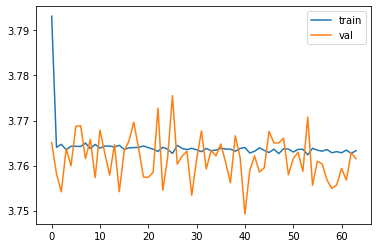

[]

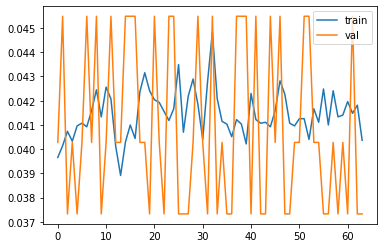

In [47]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

plt.plot(train_acc, label = 'train')
plt.plot(val_acc, label='val')
plt.legend()
plt.plot()